In [1]:
import json
import requests
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

In [4]:
response = requests.get('https://min-api.cryptocompare.com/data/histoday?fsym=ETH&tsym=CAD&limit=1000')
json.loads(response.content)['Data']

[{'time': 1540080000,
  'high': 280.19,
  'low': 276.67,
  'open': 277.1,
  'volumefrom': 798148.74,
  'volumeto': 221174582.94,
  'close': 277.11,
  'conversionType': 'multiply',
  'conversionSymbol': 'BTC'},
 {'time': 1540166400,
  'high': 274.37,
  'low': 272.2,
  'open': 277.11,
  'volumefrom': 940433.89,
  'volumeto': 256638033.38,
  'close': 272.89,
  'conversionType': 'multiply',
  'conversionSymbol': 'BTC'},
 {'time': 1540252800,
  'high': 279.93,
  'low': 274.02,
  'open': 272.89,
  'volumefrom': 871510.03,
  'volumeto': 241271343.87,
  'close': 276.84,
  'conversionType': 'multiply',
  'conversionSymbol': 'BTC'},
 {'time': 1540339200,
  'high': 276.73,
  'low': 273.4,
  'open': 276.84,
  'volumefrom': 830502.15,
  'volumeto': 227425339.94,
  'close': 273.84,
  'conversionType': 'multiply',
  'conversionSymbol': 'BTC'},
 {'time': 1540425600,
  'high': 274.38,
  'low': 272.54,
  'open': 274.32,
  'volumefrom': 876314.95,
  'volumeto': 239752358.01,
  'close': 273.59,
  'convers

In [5]:
df = pd.DataFrame(json.loads(response.content)['Data'])
df.head()

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
0,1540080000,280.19,276.67,277.10,798148.74,2.211746e+08,277.11,multiply,BTC
1,1540166400,274.37,272.20,277.11,940433.89,2.566380e+08,272.89,multiply,BTC
2,1540252800,279.93,274.02,272.89,871510.03,2.412713e+08,276.84,multiply,BTC
3,1540339200,276.73,273.40,276.84,830502.15,2.274253e+08,273.84,multiply,BTC
4,1540425600,274.38,272.54,274.32,876314.95,2.397524e+08,273.59,multiply,BTC


In [6]:
df = df.set_index('time')

In [7]:
df.head()

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
1540080000,280.19,276.67,277.10,798148.74,2.211746e+08,277.11,multiply,BTC
1540166400,274.37,272.20,277.11,940433.89,2.566380e+08,272.89,multiply,BTC
1540252800,279.93,274.02,272.89,871510.03,2.412713e+08,276.84,multiply,BTC
1540339200,276.73,273.40,276.84,830502.15,2.274253e+08,273.84,multiply,BTC
1540425600,274.38,272.54,274.32,876314.95,2.397524e+08,273.59,multiply,BTC


In [8]:
df = df[['high', 'low', 'open', 'volumefrom', 'volumeto', 'close']]
df.head()

,high,low,open,volumefrom,volumeto,close
time,,,,,,
1540080000,280.19,276.67,277.10,798148.74,2.211746e+08,277.11
1540166400,274.37,272.20,277.11,940433.89,2.566380e+08,272.89
1540252800,279.93,274.02,272.89,871510.03,2.412713e+08,276.84
1540339200,276.73,273.40,276.84,830502.15,2.274253e+08,273.84
1540425600,274.38,272.54,274.32,876314.95,2.397524e+08,273.59


In [9]:
def train_test_split(df):
    split_row = len(df) - int(0.1 * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
train, test = train_test_split(df)

In [10]:
len(test)

100

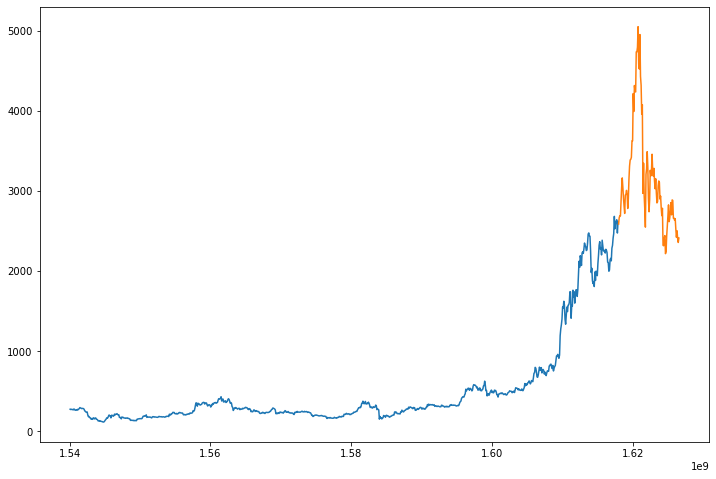

In [11]:
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.plot(train['close'], label='train_data')
ax.plot(test['close'], label='test_data')

In [12]:
def norm_zero_base(df):
    return df / df.iloc[0] - 1

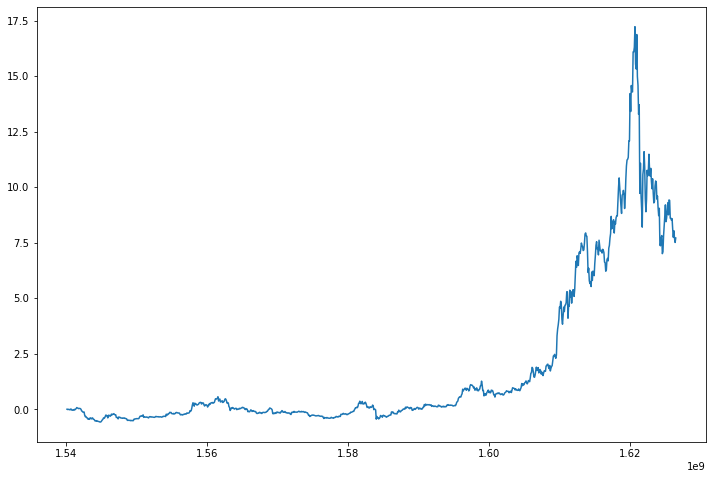

In [13]:
sample = norm_zero_base(df['close'])
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.plot(sample, label='sample')

In [14]:
def norm_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

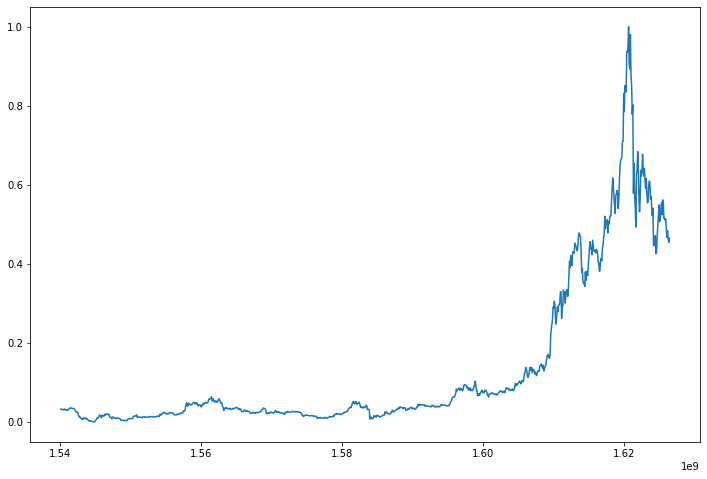

In [15]:
sample = norm_min_max(df['close'])
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.plot(sample, label='sample')

In [16]:
def extract_windows_data(df):
    window_data = []
    for idx in range(len(df) - 10):
        tmp = df[idx: (idx + 10)].copy()
        tmp = norm_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [17]:
def prepare_data(df):
    train_data, test_data = train_test_split(df)
    X_train = extract_windows_data(train_data)
    X_test = extract_windows_data(test_data)
    y_train = train_data['close'][10:].values
    y_test = test_data['close'][10:].values
    
    y_train = y_train / train_data['close'][:-10].values - 1
    y_test = y_test / test_data['close'][:-10].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test

In [18]:
train, test, X_train, X_test, y_train, y_test = prepare_data(df)

In [19]:
y_train

array([-2.86528815e-02, -2.77034703e-02, -6.61031643e-03, -1.40593047e-02,
        1.86775832e-02,  5.81858819e-02,  6.65329082e-02,  5.50911580e-02,
        8.90775325e-02,  7.50113310e-02,  6.85811940e-02,  8.10311687e-02,
        3.55987055e-02,  2.02600096e-02, -8.13060639e-02, -1.14584433e-01,
       -1.89398011e-01, -1.78328723e-01, -1.58906672e-01, -2.81884618e-01,
       -3.59002886e-01, -3.49126660e-01, -3.88693820e-01, -3.80236695e-01,
       -3.91345102e-01, -3.58301527e-01, -3.70990468e-01, -3.69519139e-01,
       -2.99518102e-01, -1.87435785e-01, -1.52682107e-01, -1.15967647e-01,
       -3.00976450e-02, -1.10707591e-01, -3.04799795e-02, -1.00371747e-01,
       -1.35063908e-01, -1.27092947e-01, -2.47721526e-01, -1.90209538e-01,
       -1.79938548e-01, -2.40547746e-01, -2.67322042e-01, -1.98524569e-01,
       -2.22317824e-01, -1.92011019e-01, -7.28214503e-02,  8.83552333e-03,
        1.26778177e-01,  1.30046844e-01,  3.17773788e-01,  3.09238870e-01,
        3.89751051e-01,  

In [20]:
X_train[0]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.07716193e-02, -1.61564319e-02,  3.60880549e-05,
         1.78268965e-01,  1.60341437e-01, -1.52286096e-02],
       [-9.27941754e-04, -9.57819785e-03, -1.51930711e-02,
         9.19143091e-02,  9.08637903e-02, -9.74342319e-04],
       [-1.23487633e-02, -1.18191347e-02, -9.38289426e-04,
         4.05355648e-02,  2.82616425e-02, -1.18003681e-02],
       [-2.07359292e-02, -1.49275310e-02, -1.00324792e-02,
         9.79343900e-02,  8.39959765e-02, -1.27025369e-02],
       [-3.30490025e-02, -3.68308816e-02, -1.26669073e-02,
         4.90127818e-02,  1.62142411e-02, -3.12511277e-02],
       [-2.56968486e-03,  4.98789171e-03, -3.12161674e-02,
         2.84024755e-03,  1.00907444e-02,  7.21735051e-03],
       [-8.81544666e-03, -3.83127914e-03,  7.25369903e-03,
        -5.84724346e-02, -5.70046090e-02,  1.55173036e-03],
       [-3.32988329e-02, -4.53970434e-02,  1.587

In [21]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(units=1))
model.add(Activation('relu'))

model.compile(loss='mse', optimizer='adam')

In [22]:
history = model.fit(X_train, y_train, epochs=200, batch_size=32, shuffle=True, verbose=1)

Epoch 1/200
28/28 [==============================] - 2s 6ms/step - loss: 0.0213
Epoch 2/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0165
Epoch 3/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0142
Epoch 4/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0142
Epoch 5/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0132
Epoch 6/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0129
Epoch 7/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0128
Epoch 8/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0115
Epoch 9/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0124
Epoch 10/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0120
Epoch 11/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0116
Epoch 12/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0120
Epoch 13/200
28/28 [=================

28/28 [==============================] - 0s 7ms/step - loss: 0.0104
Epoch 103/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0102
Epoch 104/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0101
Epoch 105/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0100
Epoch 106/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0102
Epoch 107/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0101
Epoch 108/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0101
Epoch 109/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0104
Epoch 110/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0101
Epoch 111/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0100
Epoch 112/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0101
Epoch 113/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0102
Epoch 114/200
28/28 [=========

In [23]:
targets = test['close'][10:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.10477019527477432

In [24]:
preds

array([0.08769108, 0.02650164, 0.0837535 , 0.09862617, 0.07032783,
       0.        , 0.        , 0.        , 0.08528348, 0.175706  ,
       0.2360897 , 0.17356586, 0.18941745, 0.18019107, 0.21820946,
       0.49520302, 0.41102213, 0.37682813, 0.30647498, 0.2782734 ,
       0.38493067, 0.3641345 , 0.3509851 , 0.37842923, 0.13740364,
       0.14556733, 0.14504224, 0.07286394, 0.02364986, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.13602084, 0.23322219,
       0.05513255, 0.06473371, 0.        , 0.        , 0.09331627,
       0.12077226, 0.06544964, 0.01500739, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.1747699 , 0.12556

In [25]:
targets[:10] * (preds[:10] + 1)

time
1618790400    2958.193399
1618876800    3027.605043
1618963200    3205.471816
1619049600    3303.953312
1619136000    3164.574217
1619222400    2781.240000
1619308800    2901.950000
1619395200    3146.470000
1619481600    3593.601637
1619568000    3981.399139
Name: close, dtype: float64

In [26]:
len(train[-10:]) * (preds[:10] + 1)

array([10.876911, 10.265017, 10.837535, 10.986261, 10.703279, 10.      ,
       10.      , 10.      , 10.852835, 11.75706 ], dtype=float32)

In [27]:
len(preds)

90

In [41]:
preds

array([0.08769108, 0.02650164, 0.0837535 , 0.09862617, 0.07032783,
       0.        , 0.        , 0.        , 0.08528348, 0.175706  ,
       0.2360897 , 0.17356586, 0.18941745, 0.18019107, 0.21820946,
       0.49520302, 0.41102213, 0.37682813, 0.30647498, 0.2782734 ,
       0.38493067, 0.3641345 , 0.3509851 , 0.37842923, 0.13740364,
       0.14556733, 0.14504224, 0.07286394, 0.02364986, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.13602084, 0.23322219,
       0.05513255, 0.06473371, 0.        , 0.        , 0.09331627,
       0.12077226, 0.06544964, 0.01500739, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.1747699 , 0.12556

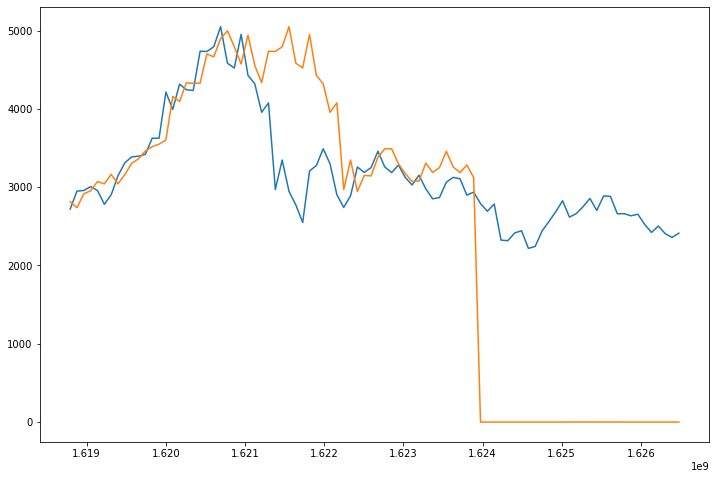

In [45]:
preds_plt = preds.copy()
preds_plt[:60] = test['close'].iloc[:60].values * (preds_plt[:60] + 1)
preds_plt = pd.Series(index=targets.index, data=preds_plt)
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.plot(targets, label='target')
ax.plot(preds_plt, label='predics')